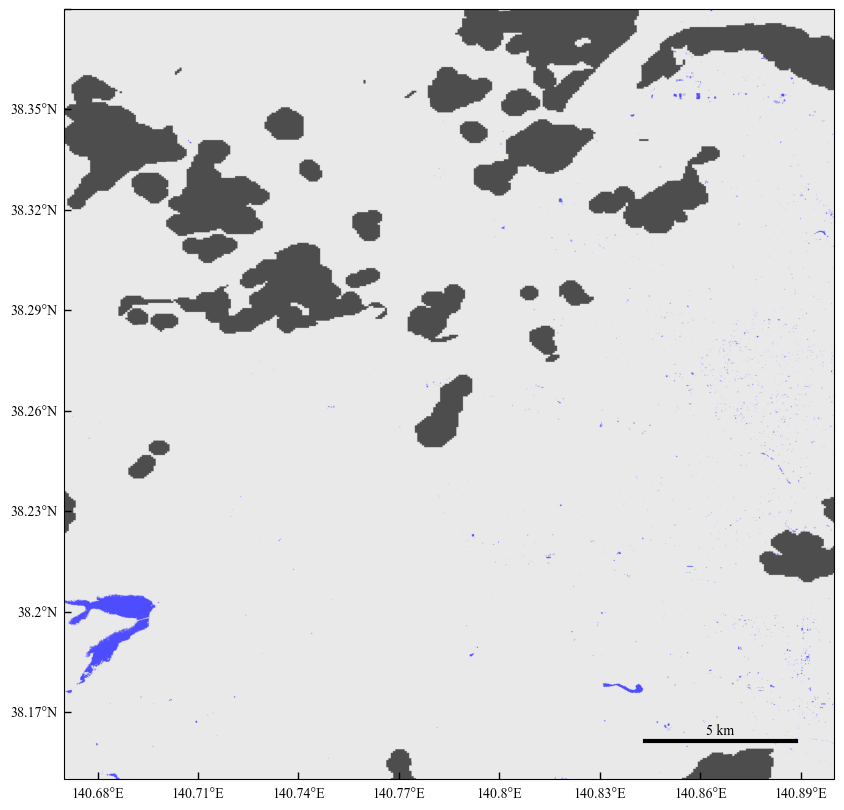

In [1]:
# Listing 1
import geemap
import ee
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import matplotlib.patches as mpatches
from matplotlib.patheffects import Stroke
from matplotlib.patheffects import withStroke

ee.Initialize()

year = 2021
month = 4
selected_layer = 'NDWI2'  # Options: 'NDWI2', 'MNDWI', 'WI2015'
satellite = 'Sentinel-2'  # Options: 'Landsat-8', 'Sentinel-2'
scale = 10
add_marker = True

export_region = ee.Geometry.BBox(140.67, 38.15, 140.90, 38.38) # Sendai
#export_region = ee.Geometry.BBox(89.61, 23.71, 90.00, 24.10) # Bangladesh
#export_region = ee.Geometry.BBox(31.37, -2.87, 34.85, 0.61) # LakeVictoria
#export_region = ee.Geometry.BBox(-0.58, 51.38, -0.28, 51.68) # London
#export_region = ee.Geometry.BBox(-60.13, -3.35, -59.88, -3.10) # Amazon River
#export_region = ee.Geometry.BBox(-83.70, 41.00, -78.70, 46.00) # Lake Erie

start_date = f'{year}-{month:02d}-01'
end_date = f'{year}-{month+1:02d}-01' if month < 12 else f'{year+1}-01-01'

shp = "continent_buff50km_simplified.shp"
land = geemap.shp_to_ee(shp)

def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_confidence = (qa.rightShift(8).bitwiseAnd(3)).lte(1)
    cloud_shadow_confidence = (qa.rightShift(10).bitwiseAnd(3)).lte(1)
    snow_ice_confidence = (qa.rightShift(12).bitwiseAnd(3)).lte(1)
    cirrus_confidence = (qa.rightShift(14).bitwiseAnd(3)).lte(1)
    return image.updateMask(cloud_confidence.And(cloud_shadow_confidence).And(snow_ice_confidence).And(cirrus_confidence))

def apply_scale_and_offset_L8(image):
    scale = 2.75e-05
    offset = -0.2
    bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    scaled = image.select(bands).multiply(scale).add(offset)
    return image.addBands(scaled, overwrite=True)

def mask_clouds_and_quality_sentinel2(image):
    qa = image.select('QA60')
    opaque_clouds = qa.bitwiseAnd(1 << 10).eq(0)
    cirrus_clouds = qa.bitwiseAnd(1 << 11).eq(0)
    mask = opaque_clouds.And(cirrus_clouds)
    return image.updateMask(mask).select(['B3', 'B4', 'B8', 'B11', 'B12'])

def apply_scale_sentinel2(image):
    scale = 0.0001
    bands = ['B3', 'B4', 'B8', 'B11', 'B12']
    scaled = image.select(bands).multiply(scale)
    return image.addBands(scaled, overwrite=True)

def calculate_indices_landsat8(image):
    ndwi2 = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI2')
    mndwi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')
    wi2015 = image.select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
                  .multiply([171, 3, -70, -45, -71]).reduce(ee.Reducer.sum()) \
                  .add(1.7204).rename('WI2015')
    return image.addBands([ndwi2, mndwi, wi2015])

def calculate_indices_sentinel2(image):
    ndwi2 = image.normalizedDifference(['B3', 'B8']).rename('NDWI2')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    wi2015 = image.select(['B3', 'B4', 'B8', 'B11', 'B12']) \
                  .multiply([171, 3, -70, -45, -71]).reduce(ee.Reducer.sum()) \
                  .add(1.7204).rename('WI2015')
    return image.addBands([ndwi2, mndwi, wi2015])

if satellite == 'Landsat-8':
    collection_landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .map(mask_clouds) \
        .map(apply_scale_and_offset_L8) \
        .map(calculate_indices_landsat8)
    image = collection_landsat8.mean().clip(land.geometry())
elif satellite == 'Sentinel-2':
    collection_sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start_date, end_date) \
        .map(mask_clouds_and_quality_sentinel2) \
        .map(apply_scale_sentinel2) \
        .map(calculate_indices_sentinel2)
    image = collection_sentinel2.mean().clip(land.geometry())
else:
    raise ValueError("Satellite must be 'Landsat-8' or 'Sentinel-2'.")

def visualize_index(image, index_name, palette):
    positive = image.select(index_name).gt(0).selfMask()
    negative = image.select(index_name).lte(0).selfMask()
    positive_vis = positive.visualize(min=0, max=1, palette=palette)
    negative_vis = negative.visualize(min=0, max=1, palette=['#e0e0e0'])
    return ee.ImageCollection([negative_vis, positive_vis]).mosaic()

# 可視化パラメータ
index_palettes = {
    'NDWI2': ['0000FF'],
    'MNDWI': ['#18db38'], 
    'WI2015': ['FF0000']
}
vis_image = visualize_index(image, selected_layer, index_palettes[selected_layer])

ndwi_numpy = geemap.ee_to_numpy(
    vis_image,
    region=export_region,
    scale=scale
)

bounds = export_region.bounds().getInfo()['coordinates'][0]
lon_min, lat_min = bounds[0]
lon_max, lat_max = bounds[2]

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

im = ax.imshow(
    ndwi_numpy,
    origin='upper',
    extent=[lon_min, lon_max, lat_min, lat_max],
    cmap='Reds',
    alpha=0.7
)

gl = ax.gridlines(
    draw_labels=True,
    alpha=0,
)

gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

gl.xlabel_style = {'size': 10, 'color': 'black', 'weight': 'normal', 'fontname': 'Times New Roman'}
gl.ylabel_style = {'size': 10, 'color': 'black', 'weight': 'normal', 'fontname': 'Times New Roman'}

ax.tick_params(
    axis='both',
    which='both',
    direction='in',
    length=5,
    width=1,
    colors='black',
    pad=5
)

xticks = gl.xlocator.tick_values(lon_min, lon_max)
yticks = gl.ylocator.tick_values(lat_min, lat_max)

ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(labelbottom=False, labeltop=False)
ax.yaxis.set_tick_params(labelleft=False, labelright=False)

def add_scalebar(ax, length_km, location='lower left', linewidth=3):
    lat_center = (lat_min + lat_max) / 2
    degree_length = length_km / 111

    if location == 'lower left':
        start_lon = lon_min + 0.05 * (lon_max - lon_min)
        start_lat = lat_min + 0.05 * (lat_max - lat_min)
    elif location == 'lower right':
        start_lon = lon_max - 0.05 * (lon_max - lon_min) - degree_length
        start_lat = lat_min + 0.05 * (lat_max - lat_min)
    else:
        raise ValueError("location must be 'lower left' or 'lower right'")

    end_lon = start_lon + degree_length

    ax.plot([start_lon, end_lon], [start_lat, start_lat], color="black", linewidth=linewidth, transform=ccrs.PlateCarree())

    ax.text(
        (start_lon + end_lon) / 2, start_lat + 0.005 * (lat_max - lat_min),
        f"{length_km} km", fontsize=10, color="black", ha="center", va="bottom", fontname='Times New Roman',
        transform=ccrs.PlateCarree()
    )

# length_km; Sendai = 5, Bangladesh = 5, Lake Victoria = 50, London = 5, Amazon river = 5, Lake Erie = 50
add_scalebar(ax, length_km=5, location='lower right')

def add_rectangle_with_label(ax, lon, lat, label, size_deg = 0.05, color='black', fill_color='white', 
                             text_color='black', show_label=True, ha="left", va="top", offset=(0.01, 0.01)):
    rect = mpatches.Rectangle(
        (lon - size_deg / 2, lat - size_deg / 2),
        size_deg, size_deg,
        linewidth=1, edgecolor=color, facecolor=fill_color, transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

    if show_label:
        ax.text(
            lon + offset[0], lat + offset[1],
            label, color=text_color, fontsize=20, weight='bold', transform=ccrs.PlateCarree(), fontname='Times New Roman',
            ha=ha, va=va
        )

locations = [
#    {"lon": 32.5777, "lat": 0.3240, "label": "Kampala", "size_deg": 0.05, "ha": "right", "va": "bottom", "offset": (0.01, 0.03)}, #Lake Victoria
#    {"lon": 32.9192, "lat": -2.5195, "label": "Mwanza", "size_deg": 0.05, "ha": "left", "va": "top", "offset": (0.03, -0.02)}, #Lake Victoria
#    {"lon": -0.4557, "lat": 51.4703, "label": "Heathrow Airport", "size_deg": 0.005, "ha": "left", "va": "bottom", "offset": (0.005, 0.005)}, #London
#    {"lon": -60.02128, "lat": -3.119369, "label": "Manaus", "size_deg": 0.005, "ha": "center", "va": "bottom", "offset": (0, 0.005)}, #Amazon    
#    {"lon": -83.04909, "lat": 42.3277, "label": "Detroit", "size_deg": 0.1, "ha": "right", "va": "bottom", "offset": (0.02, 0.03)}, #Lake Erie
#    {"lon": -79.3759, "lat": 43.6506, "label": "Toronto", "size_deg": 0.1, "ha": "right", "va": "bottom", "offset": (0.02, 0.03)}, #Lake Erie
]

for loc in locations:
    add_rectangle_with_label(
        ax, lon=loc["lon"], lat=loc["lat"], label=loc["label"], size_deg=loc["size_deg"],
        ha=loc.get("ha", "left"), va=loc.get("va", "top"), offset=loc["offset"]
    )

marker_locations = [
#    {"lon": 140.701383, "lat": 38.332076, "label": "Okura dam reservoir"}, #Sendai
#    {"lon": 140.697202, "lat": 38.189371, "label": "Kamafusa dam reservoir"}, #Sendai
#    {"lon": 140.802747, "lat": 38.274613, "label": "Hirose River"}, #Sendai
#    {"lon": 140.836048, "lat": 38.215499, "label": "Natori River"}, #Sendai
#    {"lon": 89.751180, "lat": 23.912860, "label": "Jamuna River"}, #Bangladesh
#    {"lon": 89.626753, "lat": 23.771315, "label": "Padma River"}, #Bangladesh
#    {"lon": 32.908638, "lat": -1.077795, "label": "Lake Victoria"}, #Lake Victoria
#    {"lon": -0.331308, "lat": 51.439674, "label": "the Thames"}, #London
#    {"lon": -0.529312, "lat": 51.456831, "label": "Reservoirs"}, #London
#    {"lon": -60.0187, "lat": -3.2838, "label": "Amazon River"}, #Amazon
#    {"lon": -60.0700, "lat": -3.1360, "label": "Negro River"}, #Amazon
#    {"lon": -81.2507, "lat": 42.1504, "label": "Lake Erie"}, #Lake Erie
#    {"lon": -82.4412, "lat": 43.8058, "label": "Lake Huron"}, #Lake Erie
]

def add_label(ax, lon, lat, label, text_color="white", border_color="black", fontsize=20):
    ax.text(
        lon, lat, label,
        fontsize=fontsize,
        color=text_color,
        style='italic',
        fontname='Times New Roman',
        transform=ccrs.PlateCarree(),
        path_effects=[
            withStroke(linewidth=3, foreground=border_color),
        ]
    )

for loc in marker_locations:
    add_label(ax, lon=loc["lon"], lat=loc["lat"], label=loc["label"])

output_dir = "GEE_Exports"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}/{satellite}_{selected_layer}_{year}_{month:02d}.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Listing 2
import geemap
import ee
import time
import datetime

ee.Initialize()

year = 2021
month = 4
selected_layer = 'NDWI2'  # Options: 'NDWI2', 'MNDWI', 'WI2015'
satellite = 'Sentinel-2'  # Options: 'Landsat-8', 'Sentinel-2'
scale = 300
bucket_name = 'water_index'
shp = "continent_buff50km_simplified.shp" 

start_date = f'{year}-{month:02d}-01'
end_date = f'{year}-{month+1:02d}-01' if month < 12 else f'{year+1}-01-01'

land = geemap.shp_to_ee(shp)

def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_confidence = (qa.rightShift(8).bitwiseAnd(3)).lte(1)
    cloud_shadow_confidence = (qa.rightShift(10).bitwiseAnd(3)).lte(1)
    snow_ice_confidence = (qa.rightShift(12).bitwiseAnd(3)).lte(1)
    cirrus_confidence = (qa.rightShift(14).bitwiseAnd(3)).lte(1)
    return image.updateMask(cloud_confidence.And(cloud_shadow_confidence).And(snow_ice_confidence).And(cirrus_confidence))

def apply_scale_and_offset_L8(image):
    scale = 2.75e-05
    offset = -0.2
    bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    return image.addBands(image.select(bands).multiply(scale).add(offset), overwrite=True)

def mask_clouds_and_quality_sentinel2(image):
    qa = image.select('QA60')
    opaque_clouds = qa.bitwiseAnd(1 << 10).eq(0)
    cirrus_clouds = qa.bitwiseAnd(1 << 11).eq(0)
    return image.updateMask(opaque_clouds.And(cirrus_clouds))

def apply_scale_sentinel2(image):
    scale = 0.0001
    bands = ['B3', 'B4', 'B8', 'B11', 'B12']
    return image.addBands(image.select(bands).multiply(scale), overwrite=True)

def calculate_indices_landsat8(image):
    return image.addBands([
        image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI2'),
        image.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI'),
        image.select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']).multiply([171, 3, -70, -45, -71]).reduce(ee.Reducer.sum()).add(1.7204).rename('WI2015')
    ])

def calculate_indices_sentinel2(image):
    return image.addBands([
        image.normalizedDifference(['B3', 'B8']).rename('NDWI2'),
        image.normalizedDifference(['B3', 'B11']).rename('MNDWI'),
        image.select(['B3', 'B4', 'B8', 'B11', 'B12']).multiply([171, 3, -70, -45, -71]).reduce(ee.Reducer.sum()).add(1.7204).rename('WI2015')
    ])

if satellite == 'Landsat-8':
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(start_date, end_date).map(mask_clouds).map(apply_scale_and_offset_L8).map(calculate_indices_landsat8)
elif satellite == 'Sentinel-2':
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(start_date, end_date).map(mask_clouds_and_quality_sentinel2).map(apply_scale_sentinel2).map(calculate_indices_sentinel2)
else:
    raise ValueError("Satellite must be 'Landsat-8' or 'Sentinel-2'.")

monthly_image = collection.select(selected_layer).mean().clip(land.geometry())
masked_image = monthly_image.updateMask(monthly_image.gt(0)).where(monthly_image.gt(0), 1)

regions = {
    "Eastern_Northern_Hemisphere": ee.Geometry.Polygon([[[0.0, 0.0], [180.0, 0.0], [180.0, 90.0], [0.0, 90.0], [0.0, 0.0]]]),
    "Eastern_Southern_Hemisphere": ee.Geometry.Polygon([[[0.0, 0.0], [180.0, 0.0], [180.0, -90.0], [0.0, -90.0], [0.0, 0.0]]]),
    "Western_Northern_Hemisphere": ee.Geometry.Polygon([[[-180.0, 0.0], [0.0, 0.0], [0.0, 90.0], [-180.0, 90.0], [-180.0, 0.0]]]),
    "Western_Southern_Hemisphere": ee.Geometry.Polygon([[[-180.0, 0.0], [0.0, 0.0], [0.0, -90.0], [-180.0, -90.0], [-180.0, 0.0]]])
}

folder_name = f'{satellite}_Monthly_Data/{year}/{month:02d}/{scale}'
start_time = datetime.datetime.now()
print(f'Start time: {start_time}')

for region_name, region in regions.items():
    file_name_prefix = f'{folder_name}/{satellite}_Monthly_Mean_{selected_layer}_{region_name}_{year}_{month:02d}'
    export_task = ee.batch.Export.image.toCloudStorage(
        image=masked_image,
        description=f'{satellite}_Monthly_Mean_{selected_layer}_{region_name}_{year}_{month:02d}',
        bucket=bucket_name,
        fileNamePrefix=file_name_prefix,
        region=region,
        scale=scale,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    export_task.start()
    print(f'Started exporting {region_name}...')

print('Exporting NDWI2 > 0 (water) to Google Cloud Storage for all regions...')
while any(task.active() for task in ee.batch.Task.list()):
    print('Running...')
    time.sleep(30)

end_time = datetime.datetime.now()
print(f'End time: {end_time}')
print(f'Elapsed time: {end_time - start_time}')
print('Done exporting all regions.')


In [ ]:
# Listing 3 S2_NDWI2_NE_1.ipynb
import geemap
import ee
import pandas as pd
from datetime import datetime

year = 2021
month = 1

# Initialize the Earth Engine module
ee.Initialize()

# Load and convert the land shapefile to an Earth Engine object
land_shp = "continent_buff50km_simplified.shp"
land = geemap.shp_to_ee(land_shp)  # Convert shapefile to Earth Engine object

# Convert the FeatureCollection to an Image
land_image = ee.Image.constant(1).clip(land.geometry())

# Function to mask clouds and apply quality check in Sentinel-2 data
def mask_clouds_and_quality(image):
    qa = image.select('QA60')
    
    # Bit 10: Opaque clouds (0: No opaque clouds)
    opaque_clouds = qa.bitwiseAnd(1 << 10).eq(0)
    
    # Bit 11: Cirrus clouds (0: No cirrus clouds)
    cirrus_clouds = qa.bitwiseAnd(1 << 11).eq(0)
    
    # Combine the masks
    mask = opaque_clouds.And(cirrus_clouds)
    
    return image.updateMask(mask).select(['B3', 'B8', 'QA60'])

# Function to calculate NDWI2
def calculate_ndwi2(image):
    image = image.multiply(0.0001)  # Apply scale factor of 0.0001

    # First reproject the image to avoid issues in polar regions
    image_reprojected = image.reproject(crs='EPSG:4326', scale=30)
    
    ndwi2 = image_reprojected.normalizedDifference(['B3', 'B8']).rename('NDWI2')
    return image_reprojected.addBands(ndwi2)

# Generate a list of geometries for 1-degree tiles
geometries = []
for lon in range(0, 180, 1):
    for lat in range(0, 90, 1):
        geom = ee.Geometry.Polygon([[
            [lon, lat],
            [lon + 1, lat],
            [lon + 1, lat + 1],
            [lon, lat + 1],
            [lon, lat]
        ]])
        geometries.append(geom)

# Function to calculate metrics for NDWI2
def calculate_metrics(image, year, month):
    results = []
    total_tp_ndwi2 = 0
    total_tn_ndwi2 = 0
    total_fp_ndwi2 = 0
    total_fn_ndwi2 = 0

    # Apply the land mask
    image = image.updateMask(land_image)

    ndwi2 = image.select('NDWI2')

    for i, geometry in enumerate(geometries):
        try:
            print(f"Processing tile {i+1}/{len(geometries)} for {year}-{month:02d}: {geometry.getInfo()}")

            # Check if there is any Sentinel-2 data within the tile
            sentinel_2_count_ndwi2 = ndwi2.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('NDWI2', 0)

            if sentinel_2_count_ndwi2 == 0:
                print(f"No Sentinel-2 data in tile {i+1} for {year}-{month:02d}")
                results.append({
                    'Year': year,
                    'Month': month,
                    'Tile': i+1,
                    'NDWI2_True_Positives': 0,
                    'NDWI2_True_Negatives': 0,
                    'NDWI2_False_Positives': 0,
                    'NDWI2_False_Negatives': 0,
                    'Data Status': 'No Sentinel-2 Data'
                })
                continue

            # Load JRC Global Surface Water Monthly History for the corresponding month
            jrc = ee.Image(f'JRC/GSW1_4/MonthlyHistory/{year}_{month:02d}').select('water')

            # Ensure JRC data is reprojected to the same scale and crs
            jrc_reprojected = jrc.reproject(crs='EPSG:4326', scale=30)

            # Check if there is any JRC data within the tile
            jrc_count = jrc_reprojected.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('water', 0)

            if jrc_count == 0:
                print(f"No JRC data in tile {i+1} for {year}-{month:02d}")
                results.append({
                    'Year': year,
                    'Month': month,
                    'Tile': i+1,
                    'NDWI2_True_Positives': 0,
                    'NDWI2_True_Negatives': 0,
                    'NDWI2_False_Positives': 0,
                    'NDWI2_False_Negatives': 0,
                    'Data Status': 'No JRC Data'
                })
                continue

            water_mask_ndwi2 = ndwi2.gt(0)
            non_water_mask_ndwi2 = ndwi2.lte(0)

            # Create water and non-water masks from JRC data
            jrc_water_mask = jrc_reprojected.eq(2)
            jrc_non_water_mask = jrc_reprojected.eq(1)

            # Calculate metrics for NDWI2
            true_positives_ndwi2 = water_mask_ndwi2.And(jrc_water_mask).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('NDWI2', 0)
            true_negatives_ndwi2 = non_water_mask_ndwi2.And(jrc_non_water_mask).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('NDWI2', 0)
            false_positives_ndwi2 = water_mask_ndwi2.And(jrc_non_water_mask).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('NDWI2', 0)
            false_negatives_ndwi2 = non_water_mask_ndwi2.And(jrc_water_mask).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=30,
                maxPixels=1e13
            ).getInfo().get('NDWI2', 0)

            total_tp_ndwi2 += true_positives_ndwi2
            total_tn_ndwi2 += true_negatives_ndwi2
            total_fp_ndwi2 += false_positives_ndwi2
            total_fn_ndwi2 += false_negatives_ndwi2

            # Record results for the current tile
            results.append({
                'Year': year,
                'Month': month,
                'Tile': i+1,
                'NDWI2_True_Positives': true_positives_ndwi2,
                'NDWI2_True_Negatives': true_negatives_ndwi2,
                'NDWI2_False_Positives': false_positives_ndwi2,
                'NDWI2_False_Negatives': false_negatives_ndwi2,
                'Data Status': 'Both Data Available'
            })

            # Print results for the current tile
            print(f"Tile {i+1} Results:")
            print(f"  NDWI2 - True Positives: {true_positives_ndwi2}, True Negatives: {true_negatives_ndwi2}, False Positives: {false_positives_ndwi2}, False Negatives: {false_negatives_ndwi2}")

        except Exception as e:
            print(f"Error processing tile {i+1} for {year}-{month:02d}: {e}")

    # Convert detailed results to DataFrame
    df_details = pd.DataFrame(results)

    # Save the detailed results to a CSV file
    df_details.to_csv(f'Tile_Details_JRC_Sentinel2_{year}_{month:02d}_NDWI2_NE.csv', index=False)

    print(f"Tile-wise results for {year}-{month:02d} have been saved to CSV file")

    # Calculate accuracy metrics for NDWI2
    if total_tp_ndwi2 + total_tn_ndwi2 + total_fp_ndwi2 + total_fn_ndwi2 > 0:
        accuracy_ndwi2 = (total_tp_ndwi2 + total_tn_ndwi2) / (total_tp_ndwi2 + total_tn_ndwi2 + total_fp_ndwi2 + total_fn_ndwi2)
        precision_ndwi2 = total_tp_ndwi2 / (total_tp_ndwi2 + total_fp_ndwi2) if (total_tp_ndwi2 + total_fp_ndwi2) > 0 else 0
        recall_ndwi2 = total_tp_ndwi2 / (total_tp_ndwi2 + total_fn_ndwi2) if (total_tp_ndwi2 + total_fn_ndwi2) > 0 else 0
    else:
        accuracy_ndwi2 = precision_ndwi2 = recall_ndwi2 = None

    return {
        'Year': year,
        'Month': month,
        'NDWI2_Accuracy': accuracy_ndwi2 * 100 if accuracy_ndwi2 is not None else None,
        'NDWI2_Precision': precision_ndwi2 * 100 if precision_ndwi2 is not None else None,
        'NDWI2_Recall': recall_ndwi2 * 100 if recall_ndwi2 is not None else None,
    }

# Start time
start_time = datetime.now()
print(f"Script start time: {start_time}")

# Initialize summary results list
summary_results = []

# Define start and end dates for the selected month
start_date = f'{year}-{month:02d}-01'
if month == 12:
    end_date = f'{year+1}-01-01'
else:
    end_date = f'{year}-{month+1:02d}-01'

# Load a Sentinel-2 image collection
collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .map(mask_clouds_and_quality) \
    .map(calculate_ndwi2)

# Check the size of the collection
collection_size = collection.size().getInfo()
print(f'Collection size for {year}-{month:02d}: {collection_size}')

if collection_size > 0:
    image = collection.mean()

    # Calculate metrics for NDWI2 and save results to CSV
    metrics = calculate_metrics(image, year, month)
    if metrics:
        summary_results.append(metrics)
        df_summary = pd.DataFrame(summary_results)
        df_summary.to_csv(f'Summary_NDWI2_{year}_{month:02d}_NE.csv', index=False)
        print(f"Summary results for NDWI2 {year}-{month:02d} have been saved to CSV file")
else:
    print(f"No Sentinel-2 data available for {year}-{month:02d}")

# End time
end_time = datetime.now()
print(f"Script end time: {end_time}")

# Print duration
print(f"Script duration: {end_time - start_time}")
